# Visualize the Results of VGG11 and VGG16

In [23]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

random_seed = 1989
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == "cuda":
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif device == "mps":
    torch.mps.manual_seed(random_seed)
    torch.backends.mps.deterministic = True
    torch.backends.mps.benchmark = False

print(f"Using device: {device}")

Using device: mps


In [25]:
# Load the models

vgg11_model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11_model.classifier[6] = nn.Linear(4096, 5)
out = vgg11_model.load_state_dict(torch.load("vgg11/best_model_vgg11_0001.pt"))
print(f'VGG11 Model: {out}')

vgg16_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16_model.classifier[6] = nn.Linear(4096, 5)
out2 = vgg16_model.load_state_dict(torch.load("vgg16/vgg16_0001_best.pt"))
print(f'VGG16 Model: {out2}')

VGG11 Model: <All keys matched successfully>
VGG16 Model: <All keys matched successfully>


In [26]:
# Load losses and accuracies
vgg11_losses = pd.read_csv("vgg11/losses_accuracies_vgg11_0001.csv")
vgg16_losses = pd.read_csv("vgg16/losses_accuracies_vgg16_0001.csv")

In [27]:
# Read in the data
train_label = pd.read_csv("../../data/train_label_coordinates_preprocessed_split.csv")
labels = train_label["condition"]
# Convert labels to integers
label_map = {
    "Spinal Canal Stenosis": 0,
    "Right Neural Foraminal Narrowing": 1,
    "Left Neural Foraminal Narrowing": 2,
    "Right Subarticular Stenosis": 3,
    "Left Subarticular Stenosis": 4
}
labels = labels.map(label_map)

split_set = train_label["dataset"]

path_to_image = train_label["preprocessed_file_path"]

# Create data loader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, path_to_image, labels, split_set, transform=None):
        self.path_to_image = path_to_image
        self.labels = labels
        self.transform = transform
        self.split_set = split_set

    def __len__(self):
        return len(self.path_to_image)

    def __getitem__(self, idx):
        path_starter = "../../data/"
        image = Image.open(path_starter + self.path_to_image[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_split_set(self):
        return self.split_set
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # convert from grayscale to RGB
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor()
])

batch_size = 64

# Get the train data, where split_set == "train"
train_data = ImageDataset(path_to_image, labels, split_set, transform)
train_data_indices = [i for i in range(len(train_data)) if train_data.get_split_set()[i] == "train"]
train_data = torch.utils.data.Subset(train_data, train_data_indices)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Get the validation data, where split_set == "val"
val_data = ImageDataset(path_to_image, labels, split_set, transform)
val_data_indices = [i for i in range(len(val_data)) if val_data.get_split_set()[i] == "val"]
val_data = torch.utils.data.Subset(val_data, val_data_indices)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Get the test data, where split_set == "test"
test_data = ImageDataset(path_to_image, labels, split_set, transform)
test_data_indices = [i for i in range(len(test_data)) if test_data.get_split_set()[i] == "test"]
test_data = torch.utils.data.Subset(test_data, test_data_indices)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [28]:
test_loader

In [35]:
# Evaluate the models and save the results and predictions
def evaluate(model, loader, loss_fn, device, model_name, save_predictions = False):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, labels)
            
            running_loss += batch_loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct_predictions / total_predictions * 100

    if save_predictions:
        predictions_df = pd.DataFrame({
            "labels": all_labels,
            "predictions": all_predictions,
            "probs": [p[1] for p in all_probs]
        })
        predictions_df.to_csv(f"{model_name}_predictions.csv", index=False)
        print(f"Predictions saved to {model_name}_predictions.csv")

    return epoch_loss, accuracy

def evaluate_model(model, loader, model_name, save_predictions = False):
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    loss_fn.to(device)
    loss, accuracy = evaluate(model, loader, loss_fn, device, model_name, save_predictions)
    print(f"Model: {model_name} Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")
    return loss, accuracy

vgg11_train_loss, vgg11_train_accuracy = evaluate_model(vgg11_model, train_loader, "vgg11_train")
vgg16_train_loss, vgg16_train_accuracy = evaluate_model(vgg16_model, train_loader, "vgg16_train")

vgg11_val_loss, vgg11_val_accuracy = evaluate_model(vgg11_model, val_loader, "vgg11_val")
vgg16_val_loss, vgg16_val_accuracy = evaluate_model(vgg16_model, val_loader, "vgg16_val")

vgg11_loss, vgg11_accuracy = evaluate_model(vgg11_model, test_loader, "vgg11_test", save_predictions=True)
vgg16_loss, vgg16_accuracy = evaluate_model(vgg16_model, test_loader, "vgg16_test", save_predictions=True)

Evaluating: 100%|██████████| 533/533 [02:34<00:00,  3.44it/s]


Model: vgg11_train Loss: 0.1180, Accuracy: 94.97%


Evaluating: 100%|██████████| 533/533 [04:29<00:00,  1.97it/s]


Model: vgg16_train Loss: 0.0768, Accuracy: 97.09%


Evaluating: 100%|██████████| 77/77 [00:22<00:00,  3.46it/s]


Model: vgg11_val Loss: 0.1576, Accuracy: 91.75%


Evaluating: 100%|██████████| 77/77 [00:39<00:00,  1.96it/s]


Model: vgg16_val Loss: 0.1382, Accuracy: 93.49%


Evaluating: 100%|██████████| 153/153 [00:44<00:00,  3.45it/s]


Predictions saved to vgg11_test_predictions.csv
Model: vgg11_test Loss: 0.1612, Accuracy: 91.42%


Evaluating: 100%|██████████| 153/153 [01:16<00:00,  1.99it/s]

Predictions saved to vgg16_test_predictions.csv
Model: vgg16_test Loss: 0.1481, Accuracy: 93.37%


In [31]:
# Read in the predictions
vgg11_predictions = pd.read_csv("vgg11_predictions.csv")
vgg16_predictions = pd.read_csv("vgg16_predictions.csv")

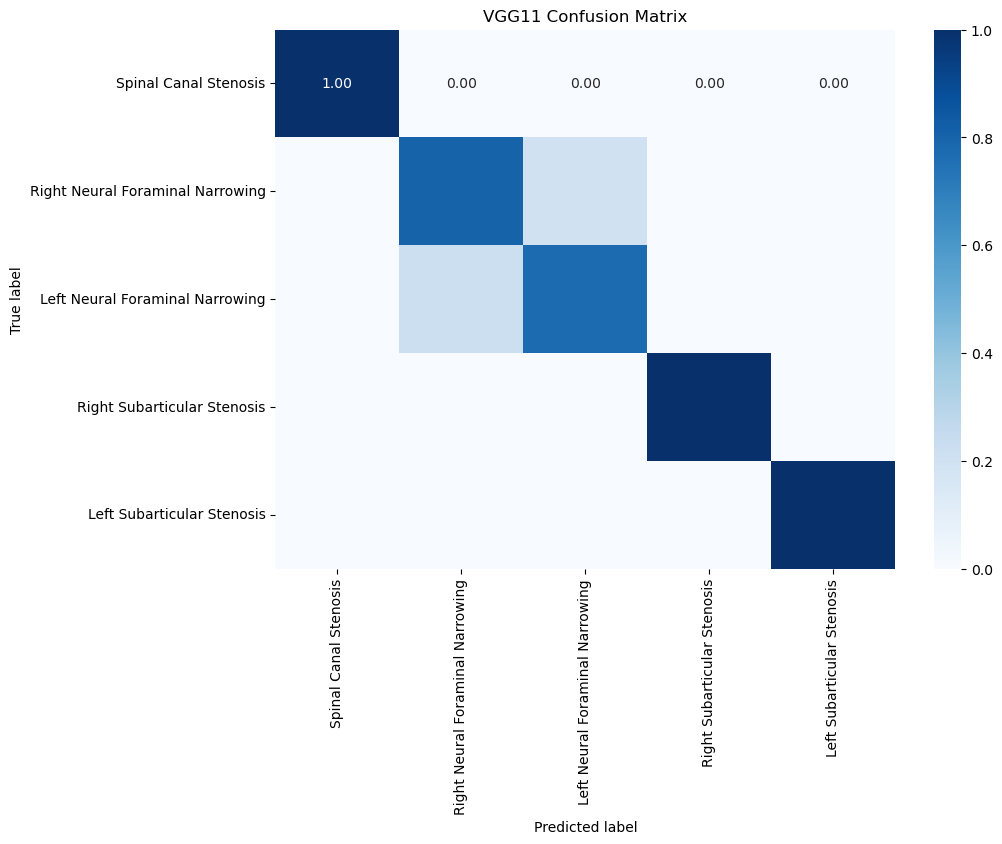

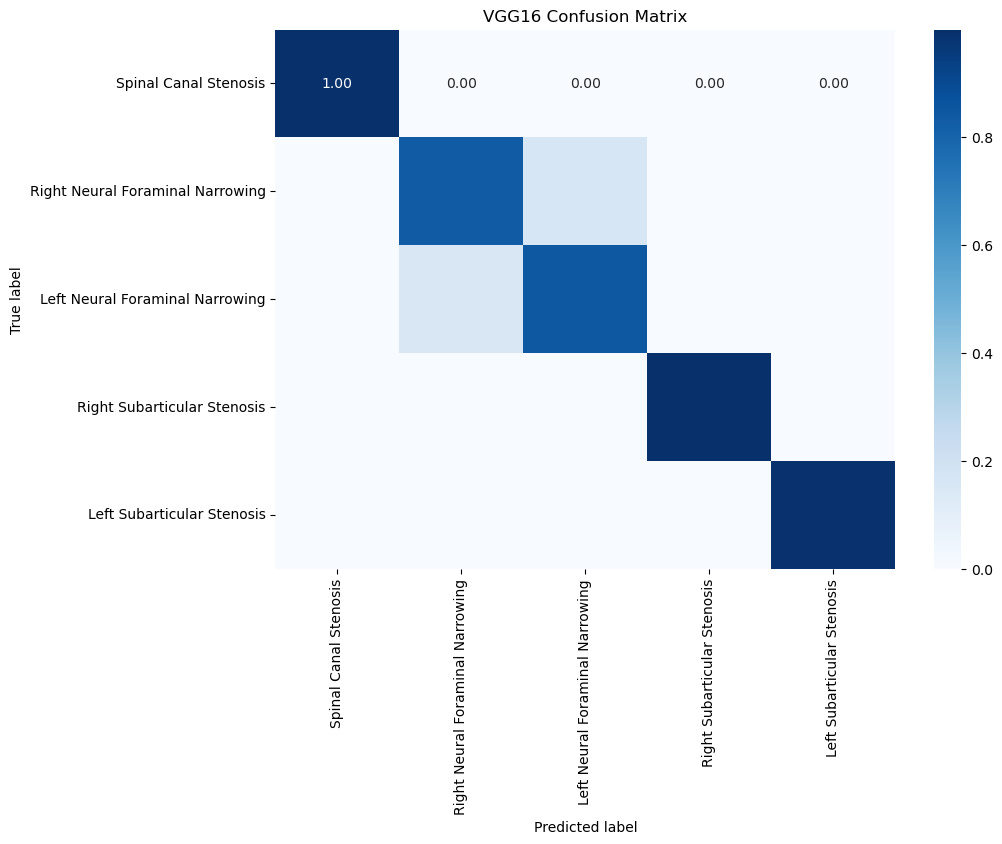

ValueError: multiclass format is not supported

<Figure size 1000x700 with 0 Axes>

In [34]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name, save_fig=False):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{model_name} Confusion Matrix")
    if save_fig:
        plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

plot_confusion_matrix(vgg11_predictions["labels"], vgg11_predictions["predictions"], "VGG11", save_fig=True)
plot_confusion_matrix(vgg16_predictions["labels"], vgg16_predictions["predictions"], "VGG16", save_fig=True)

# Generate the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs, model_name, save_fig=False):
    plt.figure(figsize=(10, 7))
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs, multi_class="ovr")
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve (AUC: {auc:.4f})")
    if save_fig:
        plt.savefig(f"{model_name}_roc_curve.png")
    plt.show()

plot_roc_curve(vgg11_predictions["labels"], vgg11_predictions["probs"], "VGG11", save_fig=True)
plot_roc_curve(vgg16_predictions["labels"], vgg16_predictions["probs"], "VGG16", save_fig=True)

# Generate the precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_probs, model_name, save_fig=False):
    plt.figure(figsize=(10, 7))
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ap = average_precision_score(y_true, y_probs)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve (AP: {ap:.4f})")
    if save_fig:
        plt.savefig(f"{model_name}_precision_recall_curve.png")
    plt.show()

plot_precision_recall_curve(vgg11_predictions["labels"], vgg11_predictions["probs"], "VGG11", save_fig=True)
plot_precision_recall_curve(vgg16_predictions["labels"], vgg16_predictions["probs"], "VGG16", save_fig=True)

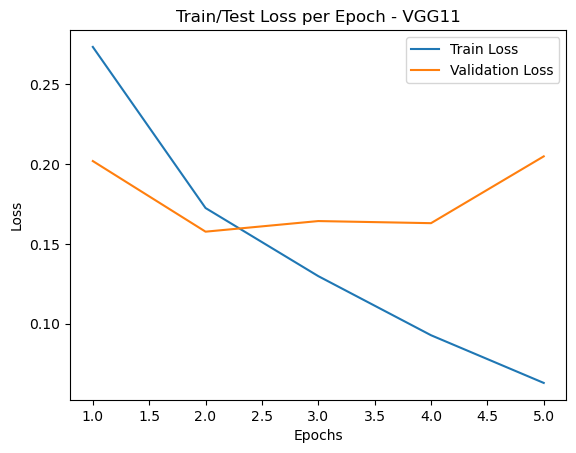

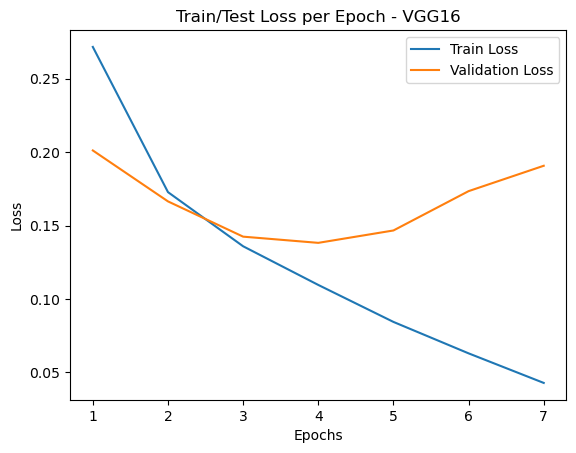

In [38]:
vgg11_loss_len = len(vgg11_losses)

fig = plt.figure()
plt.plot(np.linspace(1, vgg11_loss_len, vgg11_loss_len), vgg11_losses['train_loss'], label = 'Train Loss')
plt.plot(np.linspace(1, vgg11_loss_len, vgg11_loss_len), vgg11_losses['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch - VGG11')
plt.legend()
#save the plot
plt.savefig('vgg11_loss.png')
plt.show()

vgg16_loss_len = len(vgg16_losses)
fig = plt.figure()
plt.plot(np.linspace(1, vgg16_loss_len, vgg16_loss_len), vgg16_losses['train_loss'], label = 'Train Loss')
plt.plot(np.linspace(1, vgg16_loss_len, vgg16_loss_len), vgg16_losses['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch - VGG16')
plt.legend()
#save the plot
plt.savefig('vgg16_loss.png')
plt.show()

In [39]:
vgg11_predictions

,labels,predictions,probs
0,1,1,9.878543e-01
1,1,1,9.998547e-01
2,2,2,4.176936e-02
3,2,2,3.842267e-05
4,4,4,4.204915e-27
...,...,...,...
9734,3,3,2.267976e-11
9735,4,4,4.697903e-28
9736,4,4,1.975263e-16
9737,1,1,9.113505e-01


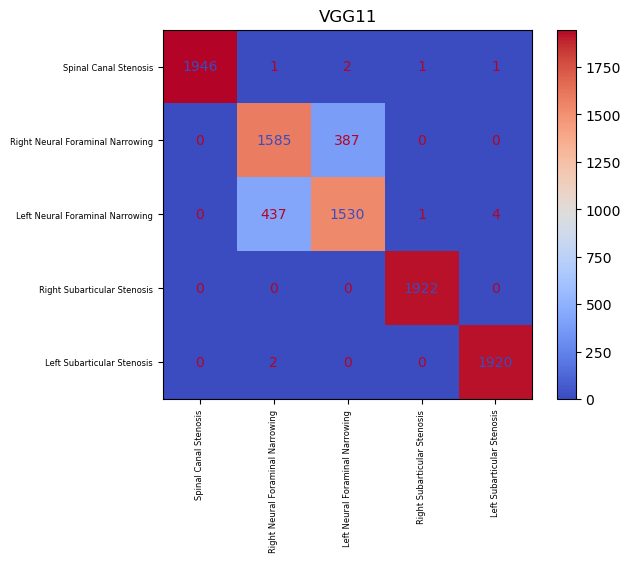

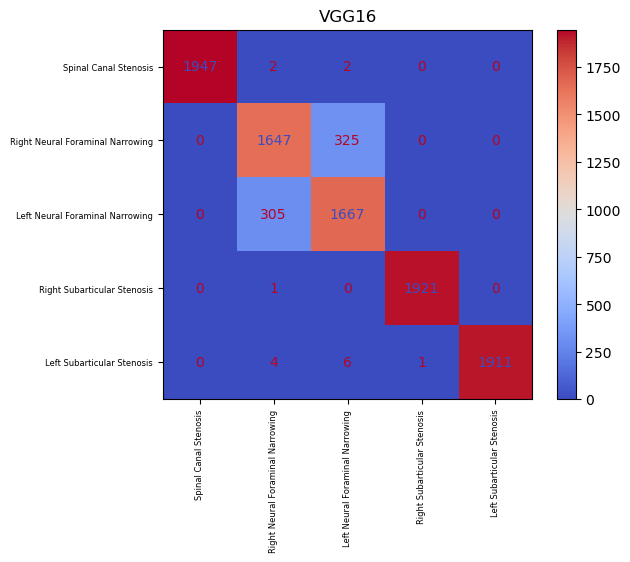

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_vgg11 = confusion_matrix(vgg11_predictions["labels"], vgg11_predictions["predictions"])
conf_vgg11_disp = ConfusionMatrixDisplay(confusion_matrix=conf_vgg11, display_labels=label_map.keys())

conf_vgg11_disp.plot(cmap = 'coolwarm')
plt.title('VGG11')
plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('')
plt.ylabel('')
conf_vgg11_disp.figure_.savefig('./vgg11_conf.jpg', dpi=2000, bbox_inches='tight')
plt.show()

conf_vgg16 = confusion_matrix(vgg16_predictions["labels"], vgg16_predictions["predictions"])
conf_vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=conf_vgg16, display_labels=label_map.keys())

conf_vgg16_disp.plot(cmap = 'coolwarm')
plt.title('VGG16')
plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('')
plt.ylabel('')
conf_vgg16_disp.figure_.savefig('./vgg16_conf.jpg', dpi=2000, bbox_inches='tight')
plt.show()